In [2]:
import numpy as np
import pandas as pd
#from ase import units
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde, linregress, t
from sklearn.metrics import r2_score


from ase.io.trajectory import Trajectory


mpl.rcParams["axes.linewidth"] =  1.5
mpl.rcParams["axes.grid"] = False

mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.right"] = True

mpl.rcParams["xtick.major.width"] = 1.5
mpl.rcParams["ytick.major.width"] = 1.5
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["xtick.minor.width"] = 1.0
mpl.rcParams["ytick.minor.width"] = 1.0
mpl.rcParams["xtick.minor.size"] =  2.5
mpl.rcParams["ytick.minor.size"] =  2.5
mpl.rcParams["xtick.direction"] =  'in'
mpl.rcParams["ytick.direction"] =  'in'
mpl.rcParams["xtick.major.size"] =  5
mpl.rcParams["ytick.major.size"] =  5

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] ='bold'
mpl.rcParams['font.size'] = 12.0
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

%matplotlib inline


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
 


def apply_kwargs(ax, x, y, kwargs):
    if kwargs is None:
        ax.plot(x, y)
    else:
        ax.plot(x, y, **kwargs)


def label_mosaic_subplot(axs, outside = False):
    for label, ax in axs.items():
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
        if outside:
           ax.annotate(
                label,
                xy=(-0.1, 1.12), xycoords='axes fraction',
                horizontalalignment='center',
                verticalalignment='center',
                #xytext=(-0.5, +0.5), textcoords='offset fontsize',
                #verticalalignment='top', # fontsize='medium', fontfamily='serif',
                #bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
                ) 
        else:
            ax.annotate(
                label,
                xy=(0, 1), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                 verticalalignment='top', 
                # fontsize='medium',
                #fontfamily='serif',
                #bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
                )


def save_figure(fig, prefix):
    for suffix in ['eps', 'pdf', 'png', 'tiff']:
        fig.savefig(f'{suffix}/{prefix}.{suffix}')



def set_ticks(ax, xlinear=True, ylinear=False, xmax=False, ymax=True, yticks = 5, xticks = 5):
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    if xlinear: ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(xticks))
    if xmax: ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(xticks))
    if ylinear: ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(yticks))
    if ymax: ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(yticks))


'''
fig, axs = plt.subplots(
    nrows = 1, ncols = 2, 
    figsize=(6.5, 3.5), dpi=600, 
    sharex = False, sharey = False, 
    layout="constrained"
    )

axs[0][0].text(
        0.1, 0.85,
        f"a)",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs[0][0].transAxes,
    )

fig.legend(loc = "outside lower center", ncols = 5, columnspacing = 1.0, handletextpad=0.4)
'''




/Users/Woody/Programs/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'\nfig, axs = plt.subplots(\n    nrows = 1, ncols = 2, \n    figsize=(6.5, 3.5), dpi=600, \n    sharex = False, sharey = False, \n    layout="constrained"\n    )\n\naxs[0][0].text(\n        0.1, 0.85,\n        f"a)",\n        horizontalalignment=\'center\',\n        verticalalignment=\'center\',\n        transform = axs[0][0].transAxes,\n    )\n\nfig.legend(loc = "outside lower center", ncols = 5, columnspacing = 1.0, handletextpad=0.4)\n'

In [3]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=4

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


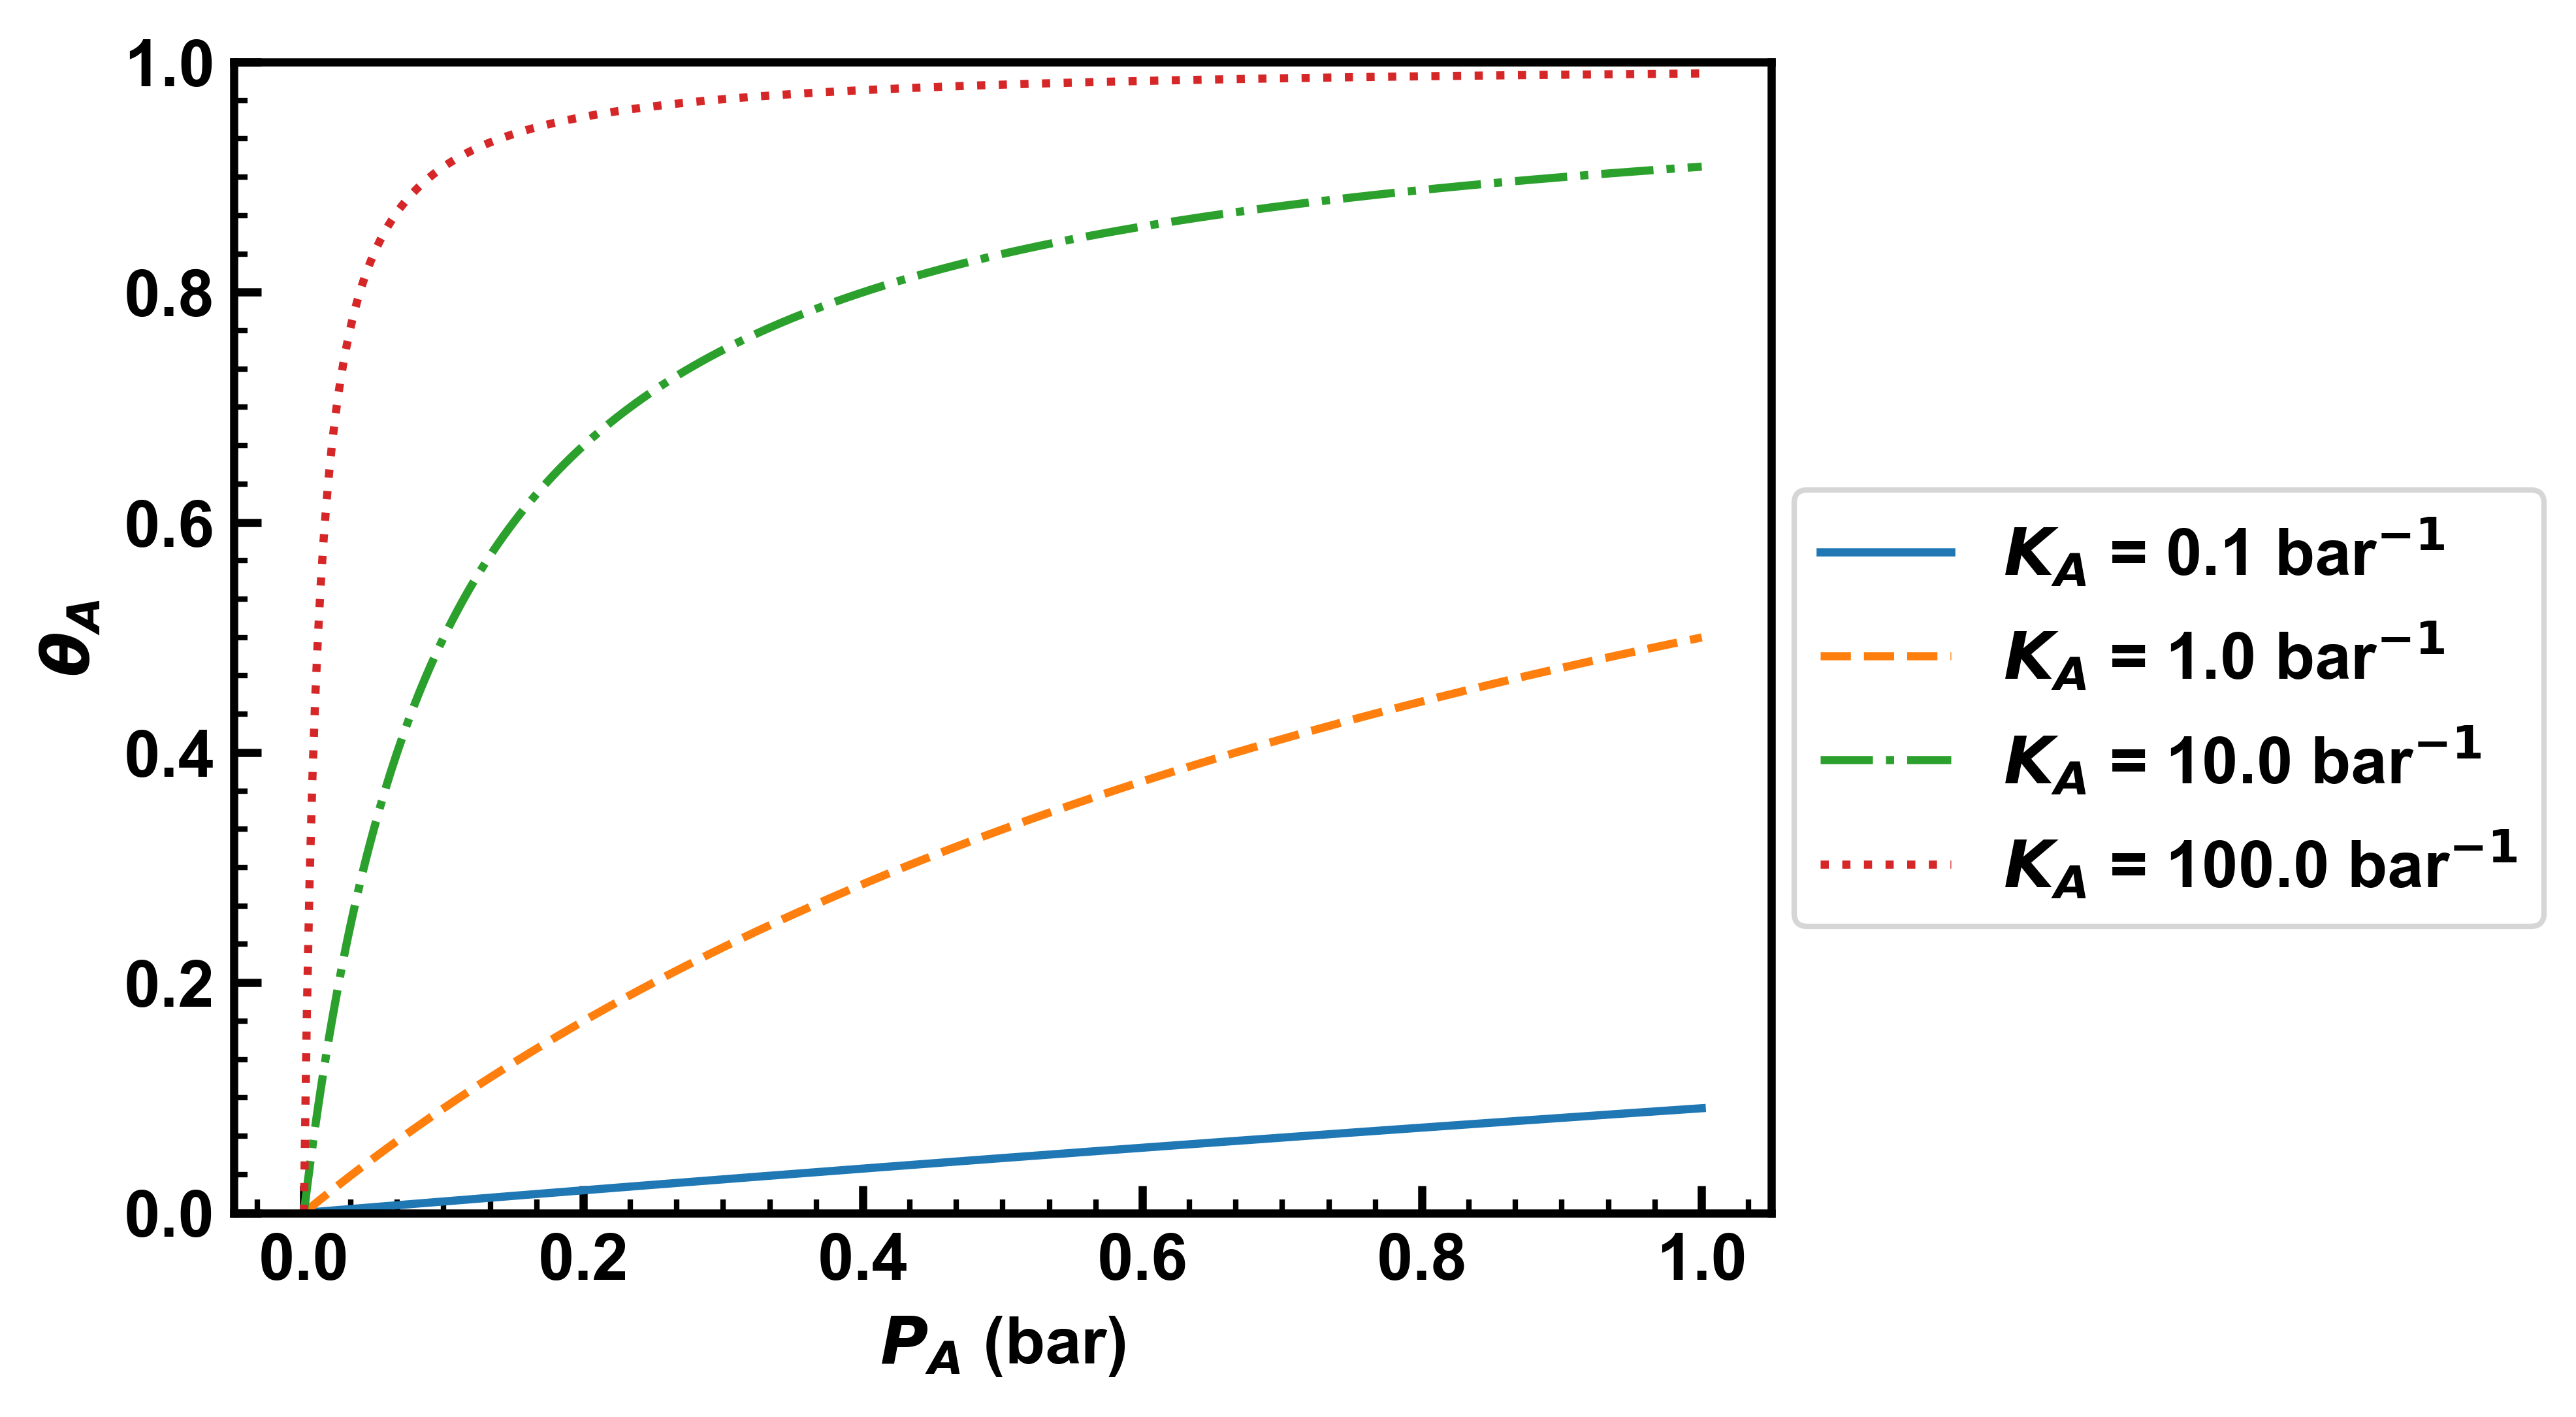

In [38]:
fig, axs = plt.subplots(
    nrows = 1, ncols = 1, 
    figsize=( 6.5, 3.5), dpi=600, 
    sharex = False, sharey = False, 
    layout="constrained"
    )

K_a = np.array([0.1, 1.0, 10.0, 100.0])
pressure = np.linspace(0, 1.0, 500, endpoint=True)

theta_a = np.zeros((len(K_a), len(pressure) ))

linestyles = ["solid", "dashed", "dashdot", "dotted"]

for i in range(len(K_a)):
    numerator =  K_a[i] * pressure
    denominator = 1 + numerator
    theta_a[i] = numerator / denominator
    axs.plot(pressure, theta_a[i], label = f"$K_A$ = {K_a[i]:.1f}" + r" bar$^{-1}$", linestyle = linestyles[i])


axs.set_ylim((0,1.0))
#axs.set_xlim((0,1.0))
axs.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))
axs.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))

fig.legend(loc = "outside center right")
#fig.legend(ncols = 2, loc = "outside lower center", )

axs.set_xlabel(r'$P_A$ (bar)')
axs.set_ylabel(r'$\theta_A$')
"""
axs.text(
        0.5, 0.5,
        r"$\theta_A = \frac{K_AP_A}{1 + K_AP_A}$",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs.transAxes,
    )
"""

save_figure(fig, prefix="langmuir")


In [8]:

theta_a

array([[0.00000000e+00, 2.04081633e-03, 4.08163265e-03, 6.12244898e-03,
        8.16326531e-03, 1.02040816e-02, 1.22448980e-02, 1.42857143e-02,
        1.63265306e-02, 1.83673469e-02, 2.04081633e-02, 2.24489796e-02,
        2.44897959e-02, 2.65306122e-02, 2.85714286e-02, 3.06122449e-02,
        3.26530612e-02, 3.46938776e-02, 3.67346939e-02, 3.87755102e-02,
        4.08163265e-02, 4.28571429e-02, 4.48979592e-02, 4.69387755e-02,
        4.89795918e-02, 5.10204082e-02, 5.30612245e-02, 5.51020408e-02,
        5.71428571e-02, 5.91836735e-02, 6.12244898e-02, 6.32653061e-02,
        6.53061224e-02, 6.73469388e-02, 6.93877551e-02, 7.14285714e-02,
        7.34693878e-02, 7.55102041e-02, 7.75510204e-02, 7.95918367e-02,
        8.16326531e-02, 8.36734694e-02, 8.57142857e-02, 8.77551020e-02,
        8.97959184e-02, 9.18367347e-02, 9.38775510e-02, 9.59183673e-02,
        9.79591837e-02, 1.00000000e-01],
       [0.00000000e+00, 2.04081633e-02, 4.08163265e-02, 6.12244898e-02,
        8.16326531e-02,